In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import pyart
import fsspec
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.cm as cm
from matplotlib import dates
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.dates as dates
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from pysteps import io, motion, rcparams
from scipy.ndimage import map_coordinates
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings;
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Pysteps configuration file found at: /Users/syed44/miniconda3/envs/pysteps/lib/python3.10/site-packages/pysteps/pystepsrc



In [2]:
def get_nexrad_files(start_datetime, end_datetime, site='KGWX', save=False, path='./nexrad_data'):
    """
    Fetches a list of NEXRAD files from an S3 bucket within a specified datetime range for a given site.
    Optionally downloads the files to a specified directory.
    
    :param start_datetime: datetime.datetime, the starting datetime of the interval.
    :param end_datetime: datetime.datetime, the ending datetime of the interval.
    :param site: str, the site code (default is 'KGWX').
    :param save: bool, whether to download the files.
    :param path: str, the directory where files should be saved if download is True.
    :return: list, sorted list of file paths.
    """
    fs = fsspec.filesystem("s3", anon=True)
    files = []

    # Adjust end_datetime to include the minute and second
    end_datetime = end_datetime.replace(minute=59, second=59)

    # Generate a list of all dates and hours between start_datetime and end_datetime
    current_datetime = start_datetime
    while current_datetime <= end_datetime:
        year = current_datetime.strftime("%Y")
        month = current_datetime.strftime("%m")
        day = current_datetime.strftime("%d")
        hour = current_datetime.strftime("%H")
        
        file_pattern = f"s3://noaa-nexrad-level2/{year}/{month}/{day}/{site}/{site}{year}{month}{day}_{hour}*6"
        daily_files = fs.glob(file_pattern)
        files.extend(daily_files)
        
        # Increment by one hour
        current_datetime += timedelta(hours=1)
    
    print(f"Found number of files: {len(files)}")
    
    if save and files:
        if not os.path.exists(path):
            os.makedirs(path)  # Create the directory if it does not exist
        
        for file in files:
            local_path = os.path.join(path, os.path.basename(file))
            if not os.path.exists(local_path):  # Check if file already exists
                fs.get(file, local_path)
                print(f"Downloaded {file} to {local_path}")
            else:
                print(f"File already exists: {local_path}")

    return sorted(files)

In [3]:
def load_data(path='./DATA/', start_dt=datetime(2022, 3, 30, 23, 0), end_dt=datetime(2022, 3, 31, 0, 59)):
    # List all files in the directory
    files = os.listdir(path)
    
    # List to store full file paths within the date range
    file_paths = []

    # Process each file to extract the timestamp and filter by date range
    for file in files:
        # Extract the date and time from the filename (assuming the format is as shown in the example)
        try:
            file_dt = datetime.strptime(file[4:17], '%Y%m%d_%H%M')
        except ValueError:
            continue  # Skip files that do not match the expected format
        
        # Check if the file is within the specified date range
        if start_dt <= file_dt <= end_dt:
            full_path = os.path.join(path, file)
            file_paths.append(full_path)
    
    # Sort the file paths by datetime extracted from filenames
    file_paths.sort(key=lambda x: datetime.strptime(os.path.basename(x)[4:17], '%Y%m%d_%H%M'))
    
    return file_paths

In [4]:
# Example usage
start_dt = datetime(2022, 3, 30, 23, 0)
end_dt = datetime(2022, 3, 31, 0, 59)
files = get_nexrad_files(start_dt, end_dt, save=True, path='./DATA/')

Found number of files: 18
File already exists: ./DATA/KGWX20220330_230555_V06
File already exists: ./DATA/KGWX20220330_231240_V06
File already exists: ./DATA/KGWX20220330_231927_V06
File already exists: ./DATA/KGWX20220330_232552_V06
File already exists: ./DATA/KGWX20220330_233252_V06
File already exists: ./DATA/KGWX20220330_233952_V06
File already exists: ./DATA/KGWX20220330_234639_V06
File already exists: ./DATA/KGWX20220330_235324_V06
File already exists: ./DATA/KGWX20220330_235959_V06
File already exists: ./DATA/KGWX20220331_000624_V06
File already exists: ./DATA/KGWX20220331_001259_V06
File already exists: ./DATA/KGWX20220331_002040_V06
File already exists: ./DATA/KGWX20220331_002655_V06
File already exists: ./DATA/KGWX20220331_003330_V06
File already exists: ./DATA/KGWX20220331_003955_V06
File already exists: ./DATA/KGWX20220331_004620_V06
File already exists: ./DATA/KGWX20220331_005306_V06
File already exists: ./DATA/KGWX20220331_005921_V06


In [5]:
# Example usage
path = './DATA/'
files = load_data(path, start_dt, end_dt)

In [6]:
files

['./DATA/KGWX20220330_230555_V06',
 './DATA/KGWX20220330_231240_V06',
 './DATA/KGWX20220330_231927_V06',
 './DATA/KGWX20220330_232552_V06',
 './DATA/KGWX20220330_233252_V06',
 './DATA/KGWX20220330_233952_V06',
 './DATA/KGWX20220330_234639_V06',
 './DATA/KGWX20220330_235324_V06',
 './DATA/KGWX20220330_235959_V06',
 './DATA/KGWX20220331_000624_V06',
 './DATA/KGWX20220331_001259_V06',
 './DATA/KGWX20220331_002040_V06',
 './DATA/KGWX20220331_002655_V06',
 './DATA/KGWX20220331_003330_V06',
 './DATA/KGWX20220331_003955_V06',
 './DATA/KGWX20220331_004620_V06',
 './DATA/KGWX20220331_005306_V06',
 './DATA/KGWX20220331_005921_V06']

In [7]:
def dealiase(radar, vel_name='velocity', gatefilter=None, method="unwrap"):
    if gatefilter is None:
        gatefilter = pyart.correct.GateFilter(radar)
        gatefilter.include_above("REF", 0)
        gatefilter.exclude_masked('REF')
        gatefilter.exclude_invalid('REF')
        gatefilter.exclude_transition()
    
    if method == "unwrap":
        corr_vel = pyart.correct.dealias_unwrap_phase(radar, vel_field=vel_name,
                                                      keep_original=False, gatefilter=gatefilter)
    elif method == "region":
        corr_vel = pyart.correct.dealias_region_based(radar, vel_field=vel_name,
                                                      keep_original=False, gatefilter=gatefilter)
    
    radar.add_field(vel_name, corr_vel, replace_existing=True)
    return radar


def filter_data(radar, refl_field, vel_field, dealias_method="region"):
    radar.scan_type = b'ppi'
    radar = dealiase(radar, vel_name=vel_field, gatefilter=None, method=dealias_method)
    return radar

def _rename_vars(radar):
    '''Rename fields if they exist'''

    if 'DBZ' in radar.fields:
        radar.fields['REF'] = radar.fields.pop('DBZ')
    if 'reflectivity' in radar.fields:
        radar.fields['REF'] = radar.fields.pop('reflectivity')
    if 'DBZH' in radar.fields:
        radar.fields['REF'] = radar.fields.pop('DBZH')
    if 'ref' in radar.fields:
        radar.fields['REF'] = radar.fields.pop('ref')
        
    if 'VELH' in radar.fields:
        radar.fields['VEL'] = radar.fields.pop('VELH')
    if 'VEL_F' in radar.fields:
        radar.fields['VEL'] = radar.fields.pop('VEL_F')
    if 'velocity' in radar.fields:
        radar.fields['VEL'] = radar.fields.pop('velocity')
        
    if 'ZDRC' in radar.fields:
        radar.fields['ZDR'] = radar.fields.pop('ZDRC')
    if 'differential_reflectivity' in radar.fields:
        radar.fields['ZDR'] = radar.fields.pop('differential_reflectivity')
        
    if 'RHOHV' in radar.fields:
        radar.fields['RHO'] = radar.fields.pop('RHOHV')
    if 'cross_correlation_ratio' in radar.fields:
        radar.fields['RHO'] = radar.fields.pop('cross_correlation_ratio')

    return radar

def process_file(outdir, rfile):
    try:
        print(f'Reading file: {os.path.basename(rfile)}')
        radar = pyart.io.read_nexrad_archive(rfile)
        radar = _rename_vars(radar)
        radar = filter_data(radar, "DBZ", "VEL")
        xy = 401
        max_rng=200*1e3
        grid_origin=(33.575864857, -88.54851899)
        grid = pyart.map.grid_from_radars(radar, (1, xy, xy),
                                          ((500,500), (-max_rng, max_rng),
                                           (-max_rng, max_rng)),
                                          grid_origin=grid_origin,
                                          weighting_function='Barnes2',
                                          fields=['REF'])

        print(f'Deleting Radar Object: {os.path.basename(rfile)}')
        del radar        
        print(f"Saving in: {grid_file_path} as {os.path.basename(rfile)}\n")
        # Write grid
        pyart.io.write_grid(filename=os.path.join(grid_file_path, os.path.basename(rfile)), grid=grid)
    except Exception as e:
        print(f"Error processing file: {os.path.basename(rfile)}")
        print(str(e))

def process_file_wrapper(args):
    return process_file(*args)

In [8]:
outdir = "./DATA/GRID/"
grid_file_path = os.path.join(outdir, "KGWX")
os.makedirs(grid_file_path, exist_ok=True)
for file in files:
    process_file(outdir, file)

Reading file: KGWX20220330_230555_V06
Deleting Radar Object: KGWX20220330_230555_V06
Saving in: ./DATA/GRID/KGWX as KGWX20220330_230555_V06

Reading file: KGWX20220330_231240_V06
Deleting Radar Object: KGWX20220330_231240_V06
Saving in: ./DATA/GRID/KGWX as KGWX20220330_231240_V06

Reading file: KGWX20220330_231927_V06
Deleting Radar Object: KGWX20220330_231927_V06
Saving in: ./DATA/GRID/KGWX as KGWX20220330_231927_V06

Reading file: KGWX20220330_232552_V06
Deleting Radar Object: KGWX20220330_232552_V06
Saving in: ./DATA/GRID/KGWX as KGWX20220330_232552_V06

Reading file: KGWX20220330_233252_V06
Deleting Radar Object: KGWX20220330_233252_V06
Saving in: ./DATA/GRID/KGWX as KGWX20220330_233252_V06

Reading file: KGWX20220330_233952_V06
Deleting Radar Object: KGWX20220330_233952_V06
Saving in: ./DATA/GRID/KGWX as KGWX20220330_233952_V06

Reading file: KGWX20220330_234639_V06
Deleting Radar Object: KGWX20220330_234639_V06
Saving in: ./DATA/GRID/KGWX as KGWX20220330_234639_V06

Reading file:

## Gridded Analysis

In [7]:
# Function definitions
def roundPartial(value, resolution, decimals=4):
    return np.around(np.round(value / resolution) * resolution, decimals=decimals)

def mtokm(val,pos):
    """Convert m to km for formatting axes tick labels"""
    val=val/1000.0
    return '%i' % val

def interpolate_all(gridded_radar, tinterp_intv, base_field_name='reflectivity_masked', use_base_field=False):
    # Get list of intervals in seconds between subsequent radar times
    tdiffs = gridded_radar['time_seconds'].diff(dim='time')
    
    # This list will hold all the time-interpolated grids (xarray Datasets). 
    # Can later be concatenated into a new xarray Dataset containing all times
    gridded_radar_interp_list = []
    
    # Grab first time from full dataset and restore singular time dimension
    first_time_ds = gridded_radar.isel(time=0)
    first_time_ds = first_time_ds.expand_dims(dim='time')

    gridded_radar_interp_list.append(first_time_ds)
    
#     tbgn = first_time_ds.coords['time_seconds'].values.item()  # Need to get scalar value, not 0-d
#                                                                # numpy array
    
    # Loop through the gridded_radar times, perform advection correction/interpolation between 
    #successive times and add each to the list, making sure the time coordinate is consistent
    # new_time = tbgn
    for i, tdiff in enumerate(tdiffs.values):
        gridded_radar_interp_sublist = advection_correction_ds(gridded_radar.isel(time=slice(i, i+2)), 
                                                               tdiff, tinterp_intv, 
                                                               base_field_name=base_field_name,
                                                               use_base_field=use_base_field)
        for t, gridded_radar_interp in enumerate(gridded_radar_interp_sublist):
#             new_time = new_time + tinterp_intv
#             new_ds = first_time_ds.copy()
#             new_ds[:] = gridded_radar_interp
#             new_ds.coords['time'] = new_ds['time'] + np.timedelta64(int(new_time), 's')
#             new_ds.coords['time_seconds'] = new_time
            gridded_radar_interp_list.append(gridded_radar_interp)
    
    return gridded_radar_interp_list


def advection_correction_ds(radar_ds, tintv_obs, tintv,
                            base_field_name='reflectivity_masked', 
                            use_base_field=False, method="LK"):
    # Evaluate advection
    oflow_method = motion.get_method(method)
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects

    # Decide whether to use a single optical flow field for all fields in the Dataset
    # (using the "base" field) or to use separate ones for each field
    base_field = radar_ds[base_field_name]
    if use_base_field:
        oflow_field = oflow_method(base_field, fd_kwargs=fd_kwargs)
        oflow_field_list = [oflow_field] * len(radar_ds.items())
    else:
        oflow_field_list = []
        for field_name, field_da in radar_ds.items():
            oflow_field = oflow_method(field_da, fd_kwargs=fd_kwargs)
            oflow_field_list.append(oflow_field)
            
    # Perform temporal interpolation on all variables in Dataset using the flow field derived from either 
    # the "base" field (by default, reflectivity), or each field individually
    
    tbgn = base_field[0].coords['time_seconds'].values.item()   # Need to get scalar value, not 0-d
                                                                # numpy array
    print(tbgn)
    print(tintv)
    radar_ds_list = []
    x, y = np.meshgrid(
        np.arange(base_field[0].shape[1], dtype=float), np.arange(base_field[0].shape[0], dtype=float),
    )
    
    new_time = tbgn
    for i in np.arange(tintv, tintv_obs + tintv, tintv):
        new_time = new_time + tintv
        field_interp_list = []
        for field_da, oflow_field in zip(radar_ds.values(), oflow_field_list):
            pos1 = (y - i / tintv_obs * oflow_field[1], 
                    x - i / tintv_obs * oflow_field[0])
            pos2 = (y + (tintv_obs - i) / tintv_obs * oflow_field[1], 
                    x + (tintv_obs - i) / tintv_obs * oflow_field[0])

            fieldt1 = map_coordinates(field_da[0], pos1, order=1)
            fieldt2 = map_coordinates(field_da[1], pos2, order=1)

            field_interp = field_da.isel(time=[0]).copy()
            field_interp[:] = ((tintv_obs - i) * fieldt1 + i * fieldt2) / tintv_obs
            try:
                field_interp.coords['time'] = field_interp['time'] + np.timedelta64(int(new_time - tbgn), 's')
            except TypeError:
                field_interp.coords['time'] = field_interp['time'] + timedelta(seconds=int(new_time - tbgn))
            field_interp.coords['time_seconds'] = new_time
            field_interp_list.append(field_interp)

        radar_ds_interp = xr.merge(field_interp_list)
        radar_ds_list.append(radar_ds_interp)
        
    return radar_ds_list

def advection_correction(arr, tintv_obs, tintv):
    """
    R = np.array([qpe_previous, qpe_current])
    T = time between two observations (5 min)
    t = interpolation timestep (1 min)
    """

    # Evaluate advection
    oflow_method = motion.get_method("LK")
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects
    V = oflow_method(arr, fd_kwargs=fd_kwargs)

    # Perform temporal interpolation
    # arr_d = np.zeros((arr[0].shape))
    arr_list = []
    x, y = np.meshgrid(
        np.arange(arr[0].shape[1], dtype=float), np.arange(arr[0].shape[0], dtype=float),
    )
    for i in np.arange(tintv, tintv_obs + tintv, tintv):

        pos1 = (y - i / tintv_obs * V[1], x - i / tintv_obs * V[0])
        R1 = map_coordinates(arr[0], pos1, order=1)
        
        pos2 = (y + (tintv_obs - i) / tintv_obs * V[1], x + (tintv_obs - i) / tintv_obs * V[0])
        R2 = map_coordinates(arr[1], pos2, order=1)

        arr_interp = ((tintv_obs - i) * R1 + i * R2) / tintv_obs
        arr_list.append(arr_interp)

    return arr_list


def interp_pyart_grid_to_PIPS(grid_ds, PIPS_loc_list):
    """Interpolate pyart gridded radar to PIPS locations given an xarray dataset with pyart grid
    info and a list of PIPS lats, lons, and altitudes. Returns lists of PIPS x, y, and z locations
    in radar grid coordinatesand a list of xarray Datasets for each grid variable interpolated to
    each PIPS location."""

    # TODO: instead of returning lists, maybe make the PIPS name a dimension of a new xarray Dataset
    
    ctrlat = float(grid_ds.origin_latitude.mean().values)
    ctrlon = float(grid_ds.origin_longitude.mean().values)
    print(ctrlat, ctrlon)

    radar_at_PIPS_list = []
    PIPS_x_list = []
    PIPS_y_list = []
    PIPS_z_list = []

    for PIPS_loc in PIPS_locs:
        PIPS_lat = PIPS_loc[0]
        PIPS_lon = PIPS_loc[1]
        PIPS_alt = PIPS_loc[2]
        radar_alt = float(grid_ds.origin_altitude.mean().values)
        
        PIPS_z = PIPS_alt - radar_alt
        PIPS_z_list.append(PIPS_z)
        # Use this function to get the x and y coords of the PIPS. Note that this will only be correct 
        # if the radar
        # grid was created using the default pyart aeqd projection.
        PIPS_x, PIPS_y = pyart.core.geographic_to_cartesian_aeqd(PIPS_lon, PIPS_lat, ctrlon, ctrlat)
        PIPS_x = PIPS_x.squeeze().item()
        PIPS_y = PIPS_y.squeeze().item()
        PIPS_x_list.append(PIPS_x)
        PIPS_y_list.append(PIPS_y)
        print('PIPS lat, lon, alt: ', PIPS_lat, PIPS_lon, PIPS_alt)
        print('PIPS x, y, z: ', PIPS_x, PIPS_y, PIPS_z)
        radar_at_PIPS_ds = grid_ds.interp(x=PIPS_x, y=PIPS_y)
        radar_at_PIPS_list.append(radar_at_PIPS_ds)

    return PIPS_x_list, PIPS_y_list, PIPS_z_list, radar_at_PIPS_list

### Load Grid

In [8]:
files = sorted(load_data(path="./DATA/GRID/KGWX/"))
len(files)

18

In [9]:
plots_dir = "DATA/GRID/PLOTS/"
os.makedirs(plots_dir, exist_ok=True)

In [10]:
ds = xr.open_mfdataset(files)

In [11]:
rounded_times = ds['time'].dt.round('60S')
ds['time'] = rounded_times
time_seconds = (ds['time'] - ds['time'][0]) / np.timedelta64(1, 's')
# print(time_seconds)
ds.coords['time_seconds'] = ('time', time_seconds.data)

In [12]:
height = 500.
# Extract one level from the gridded radar Dataset
ds_onelevel = ds.sel(z=height).squeeze()
ds_onelevel = ds_onelevel.transpose("time", "y", "x")

In [13]:
ref_varname = 'REF'
zdr_varname = 'ZDR'
rhv_varname = 'RHO'

<xarray.DataArray 'time' (time: 16)> Size: 128B
array(['2022-03-30T23:13:00.000000000', '2022-03-30T23:19:00.000000000',
       '2022-03-30T23:26:00.000000000', '2022-03-30T23:33:00.000000000',
       '2022-03-30T23:40:00.000000000', '2022-03-30T23:47:00.000000000',
       '2022-03-30T23:53:00.000000000', '2022-03-31T00:00:00.000000000',
       '2022-03-31T00:06:00.000000000', '2022-03-31T00:13:00.000000000',
       '2022-03-31T00:21:00.000000000', '2022-03-31T00:27:00.000000000',
       '2022-03-31T00:34:00.000000000', '2022-03-31T00:40:00.000000000',
       '2022-03-31T00:46:00.000000000', '2022-03-31T00:53:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time          (time) datetime64[ns] 128B 2022-03-30T23:13:00 ... 2022-03-...
    z             float64 8B 500.0
    time_seconds  (time) float64 128B 420.0 780.0 1.2e+03 ... 6e+03 6.42e+03
Attributes:
    long_name:      Time of grid
    standard_name:  time
2022-03-30 23:13:00
6.535200452980606 10.841442743300625
2022

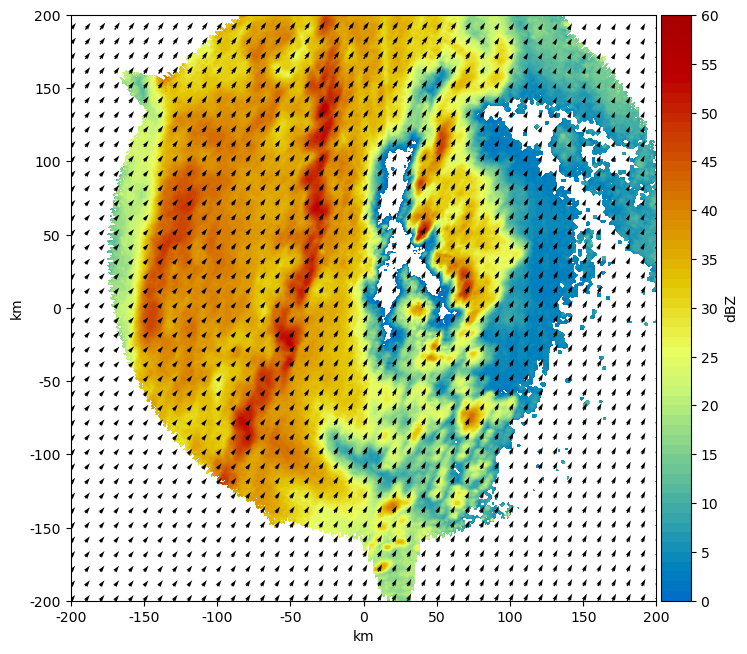

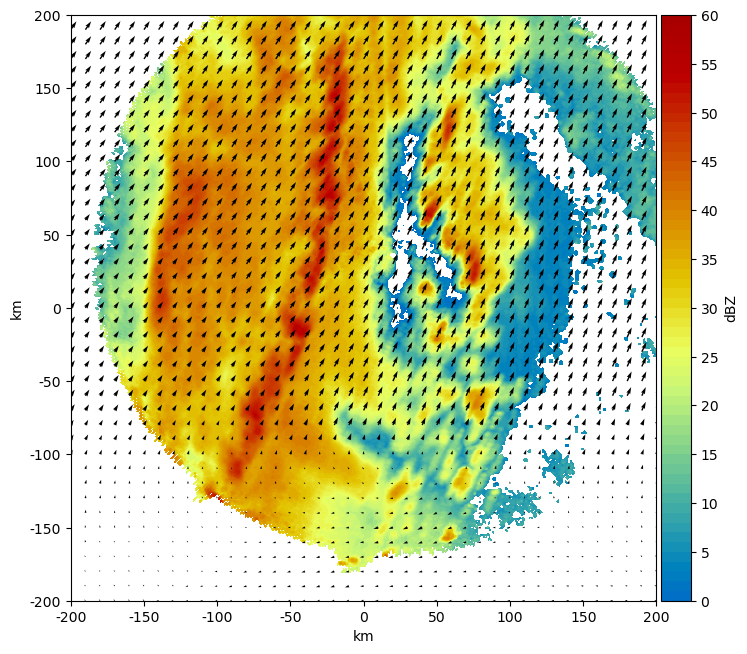

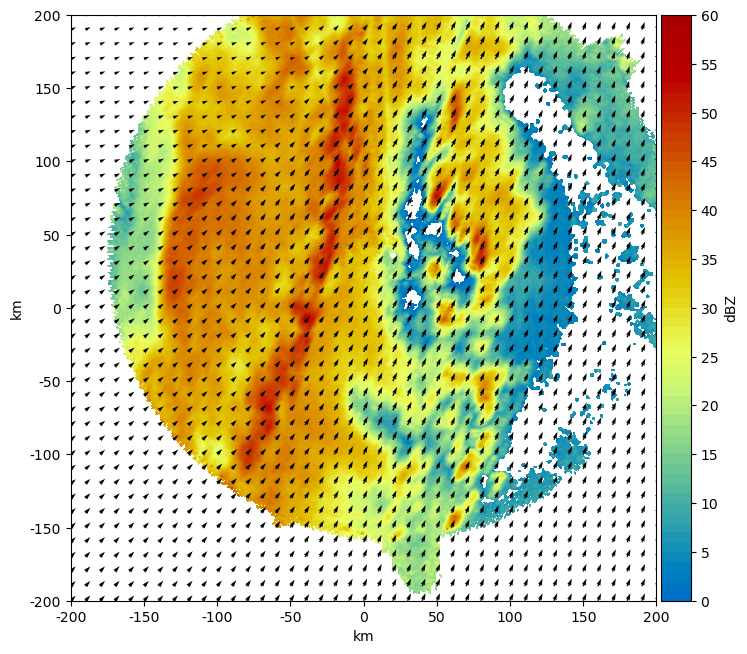

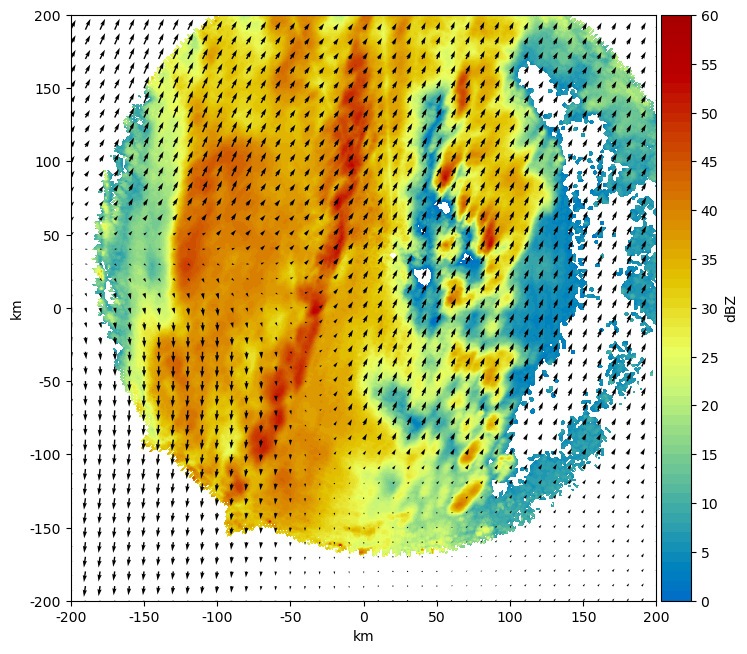

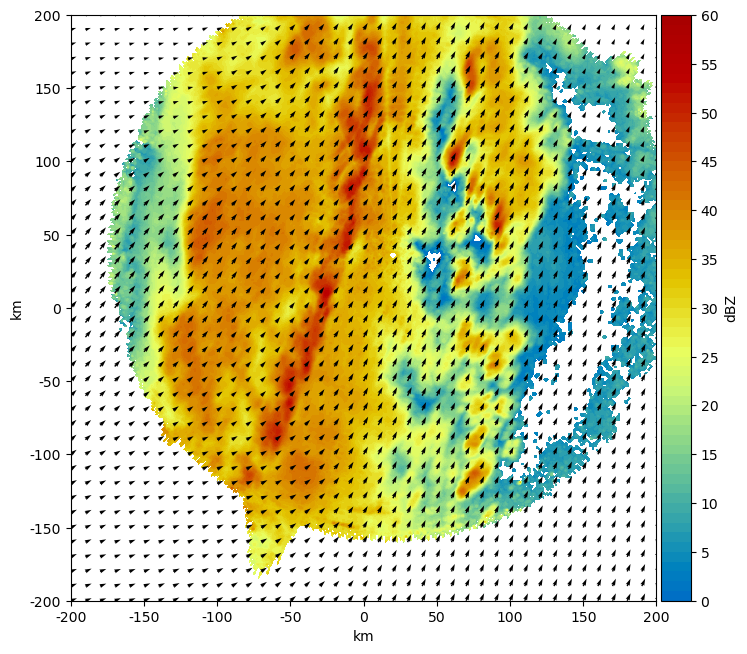

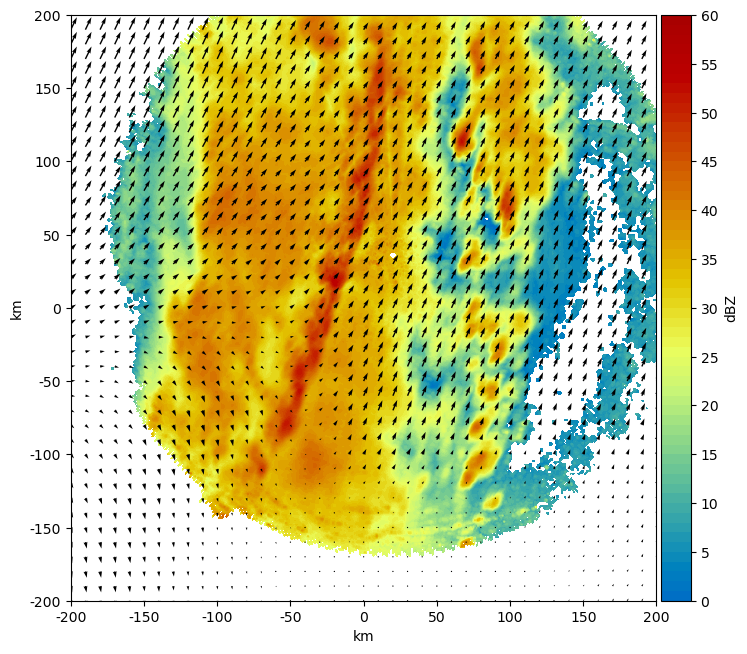

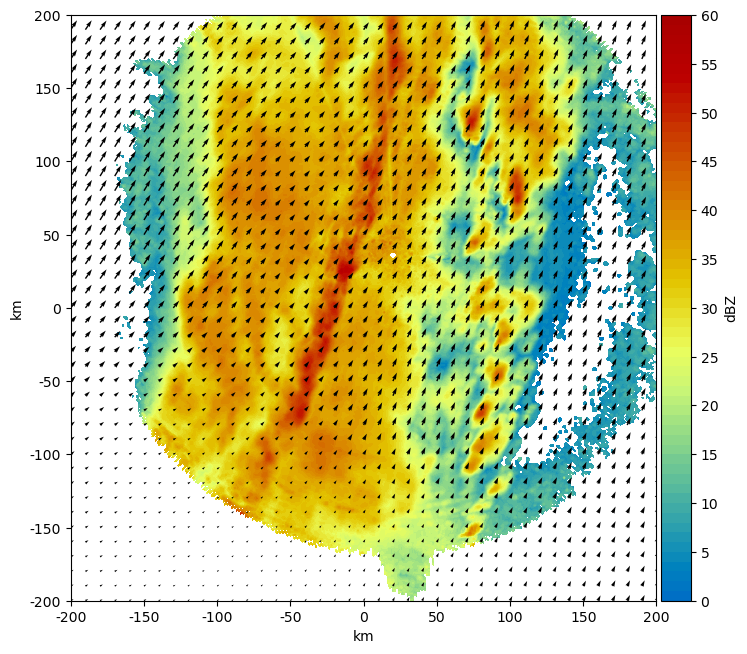

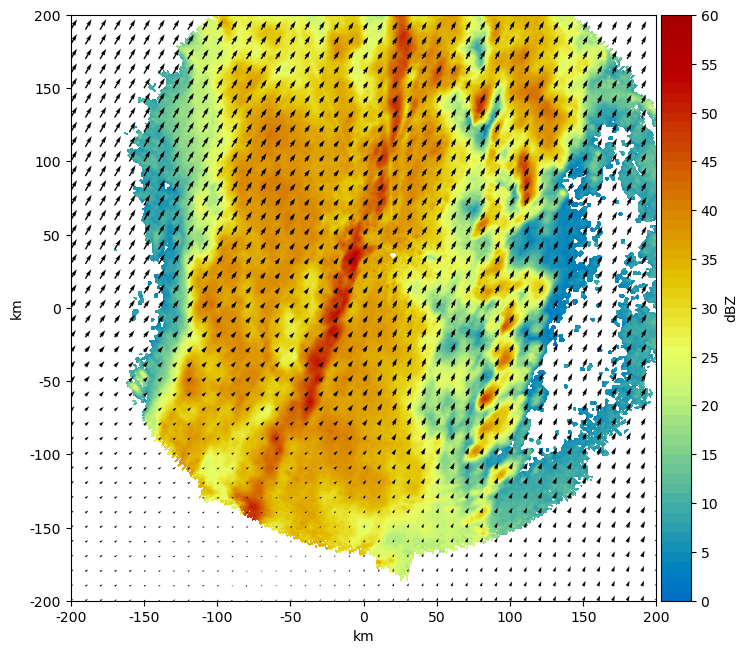

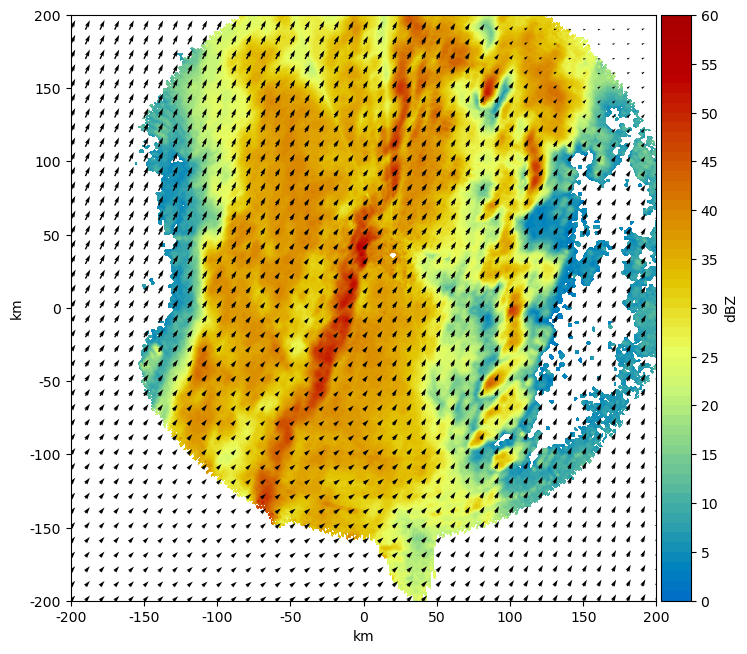

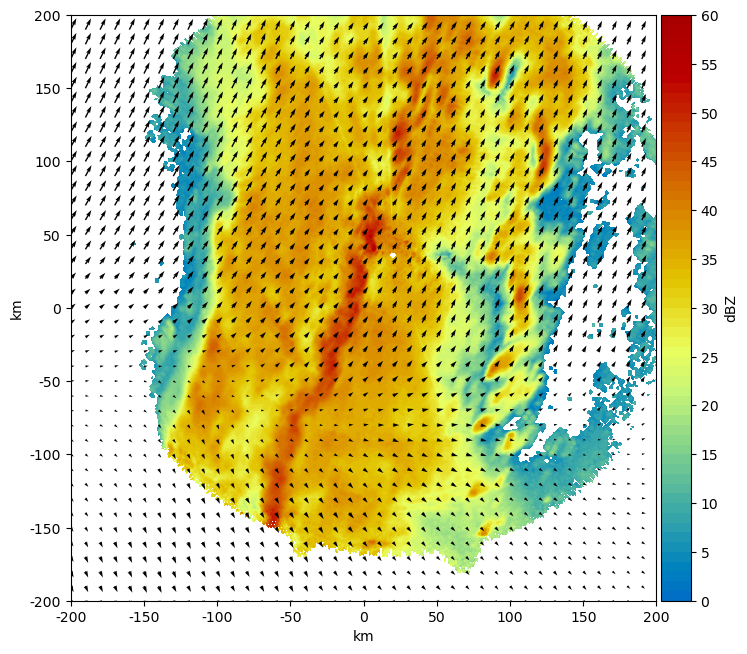

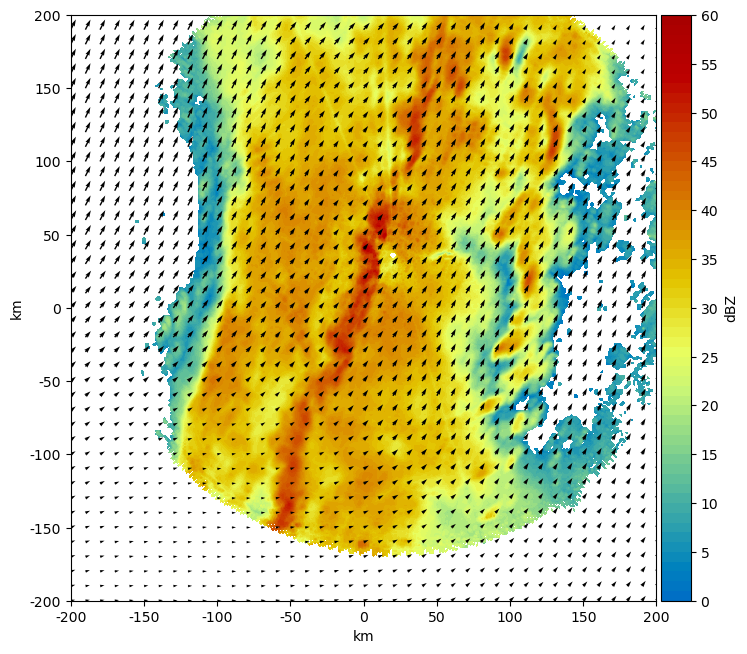

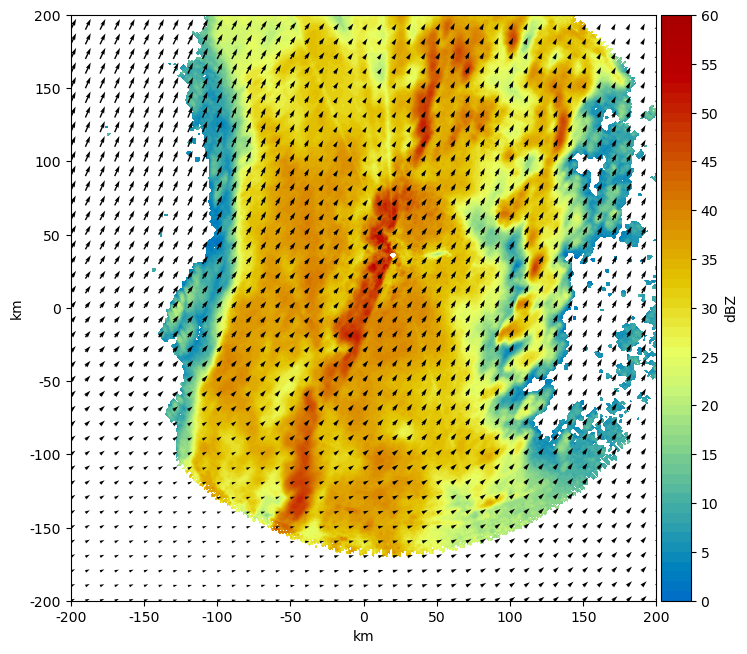

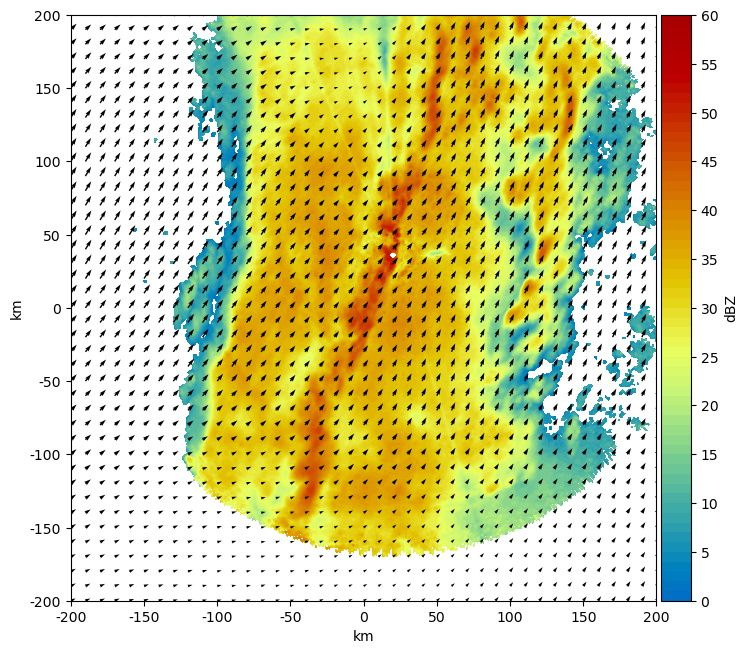

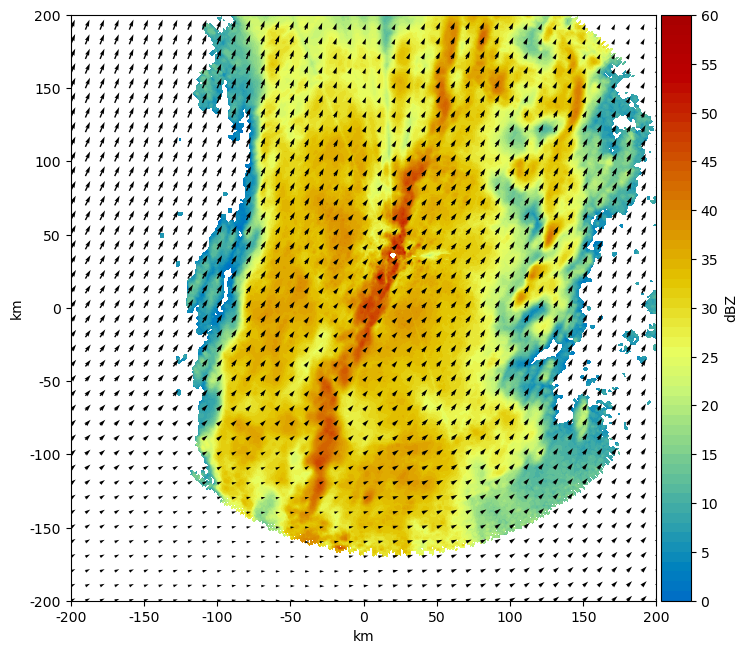

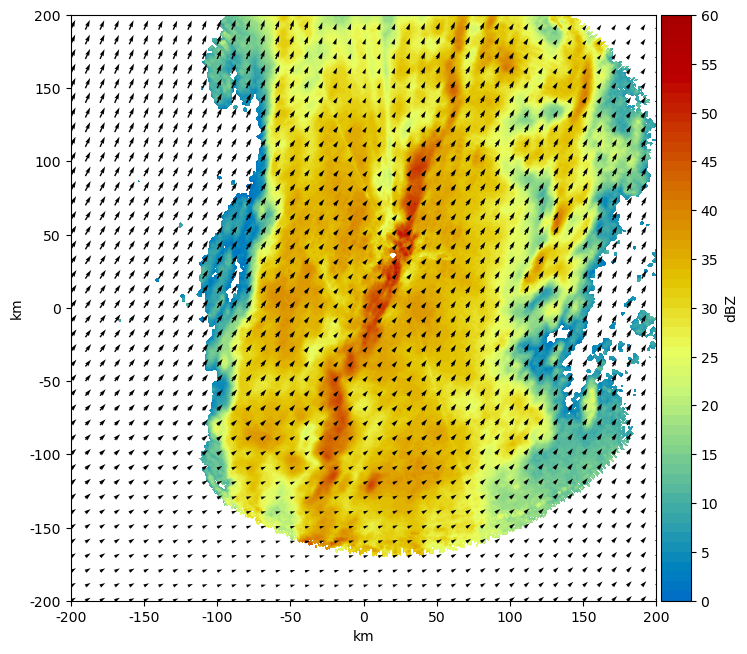

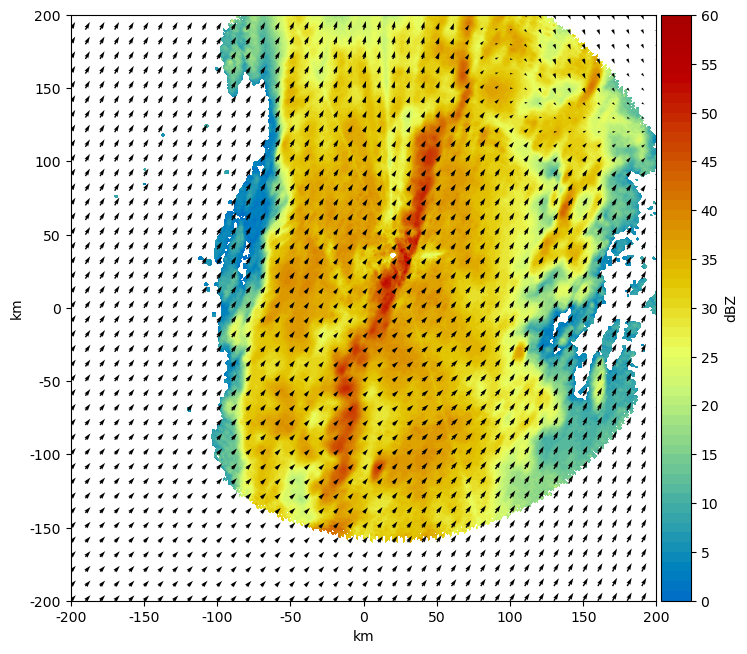

In [14]:
oflow_method = motion.get_method("LK")
fd_kwargs = {"buffer_mask": 10} # avoid edge effects

# Plot optical flow field for reflectivity as a function of time

clevels = np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=clevels[0], vmax=clevels[-1])
cmap = 'pyart_HomeyerRainbow'
# cmap = cm.plasma
cbarintv = 5.
# cbarlevels = ticker.MultipleLocator(base=cbarintv)
cbarlevels = np.arange(clevels[0], clevels[-1] + cbarintv, cbarintv)
xplt = ds_onelevel['x'].values
yplt = ds_onelevel['y'].values
dBZ = ds_onelevel[ref_varname]
times = dBZ['time'][1:-1]
print(times)

uplt_mean_list = []
vplt_mean_list = []
for t, curtime in enumerate(times):
    # print(t, t+2)
    # print(curtime)
    curtime_datetime = pd.to_datetime(curtime.values).to_pydatetime()
    # TODO: the following works (and the above no longer does). Need to find out what is really
    # going on with all these different datetime classes
    # EDIT: ok, now this no longer works, so reverting back to the previous. This is insane...
    # curtime_datetime = curtime.values.item()
    print(curtime_datetime)
    curtime_stamp = curtime_datetime.strftime('%Y%m%d%H%M%S')
    velocity_field = oflow_method(dBZ[t:t+2], fd_kwargs=fd_kwargs)
    qintv = 10
    uplt = velocity_field[0]
    vplt = velocity_field[1]
    fig, ax = plt.subplots(figsize=(8, 8))
    dBZ_plt = ax.contourf(xplt, yplt, dBZ[t+1].values, levels=clevels, cmap=cmap, norm=norm)
    ax.quiver(xplt[::qintv], yplt[::qintv], uplt[::qintv,::qintv], vplt[::qintv,::qintv])
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(dBZ_plt, orientation='vertical', cax=cax, ticks=cbarlevels)
    cax.set_ylabel('dBZ')
    formatter = ticker.FuncFormatter(mtokm)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
    ax.set_xlabel('km')
    ax.set_ylabel('km')
    ax.set_aspect('equal')

    plot_filename='pysteps_adv_correction_{}.png'.format(curtime_stamp)
    plot_filepath = os.path.join(plots_dir, plot_filename)
    fig.savefig(plot_filepath, dpi=300, bbox_inches='tight')

    print(uplt.mean(), vplt.mean())
    uplt_mean_list.append(uplt.mean())
    vplt_mean_list.append(vplt.mean())

In [15]:
# gridded_Z_ZDR_RHV = ds_onelevel[[ref_varname, zdr_varname, rhv_varname]]
gridded_Z_ZDR_RHV = ds_onelevel[[ref_varname]]

tinterp_intv = 60.

gridded_Z_ZDR_RHV_interp_list = interpolate_all(gridded_Z_ZDR_RHV, tinterp_intv, 
                                                base_field_name=ref_varname, use_base_field=True)

0.0
60.0
420.0
60.0
780.0
60.0
1200.0
60.0
1620.0
60.0
2040.0
60.0
2460.0
60.0
2820.0
60.0
3240.0
60.0
3600.0
60.0
4020.0
60.0
4500.0
60.0
4860.0
60.0
5280.0
60.0
5640.0
60.0
6000.0
60.0
6420.0
60.0


In [16]:
gridded_Z_ZDR_RHV_interp_ds = xr.concat(gridded_Z_ZDR_RHV_interp_list, 'time')
gridded_Z_ZDR_RHV_interp_ds

<xarray.Dataset> Size: 73MB
Dimensions:       (time: 114, y: 401, x: 401)
Coordinates:
  * time          (time) datetime64[ns] 912B 2022-03-30T23:06:00 ... 2022-03-...
  * x             (x) float64 3kB -2e+05 -1.99e+05 -1.98e+05 ... 1.99e+05 2e+05
  * y             (y) float64 3kB -2e+05 -1.99e+05 -1.98e+05 ... 1.99e+05 2e+05
    z             float64 8B 500.0
    time_seconds  (time) float64 912B 0.0 60.0 120.0 ... 6.72e+03 6.78e+03
Data variables:
    REF           (time, y, x) float32 73MB dask.array<chunksize=(1, 401, 401), meta=np.ndarray>
Attributes:
    Conventions:         CF/Radial instrument_parameters
    version:             1.3
    title:               
    institution:         
    references:          
    source:              
    history:             
    comment:             
    instrument_name:     KGWX
    original_container:  NEXRAD Level II
    vcp_pattern:         212

In [17]:
# Check to see if masked versions of ZH, ZDR, and RHV exist in the file. 
# If not, create them here.

mask_anyway = True
ZH_thresh = 5.
ZDR_thresh = 0.1
RHV_thresh = 0.95

print("Z, ZDR, RHV thresholds are {:f}, {:f}, {:f}".format(ZH_thresh, ZDR_thresh, RHV_thresh))

if 'reflectivity_masked' not in gridded_Z_ZDR_RHV_interp_ds or mask_anyway:
    print("Masking Z, ZDR, and RHV on thresholds of {:f}, {:f}, {:f}".format(ZH_thresh, ZDR_thresh, RHV_thresh))
    ZH_mask = np.where(gridded_Z_ZDR_RHV_interp_ds[ref_varname] < ZH_thresh, True, False)
    ZH_mask = np.where(np.isfinite(gridded_Z_ZDR_RHV_interp_ds[ref_varname]), ZH_mask, False)
#     ZDR_mask = np.where(gridded_Z_ZDR_RHV_interp_ds[zdr_varname] < ZDR_thresh, True, False)
#     ZDR_mask = np.where(np.isfinite(gridded_Z_ZDR_RHV_interp_ds[zdr_varname]), ZDR_mask, False)
#     RHV_mask = np.where(gridded_Z_ZDR_RHV_interp_ds[rhv_varname] < RHV_thresh, True, False)
#     RHV_mask = np.where(np.isfinite(gridded_Z_ZDR_RHV_interp_ds[rhv_varname]), RHV_mask, False)
#     full_mask = np.ma.mask_or(ZH_mask, ZDR_mask)
#     full_mask = np.ma.mask_or(full_mask, RHV_mask)

#     gridded_Z_ZDR_RHV_interp_ds[f'{ref_varname}_masked'] = \
#         gridded_Z_ZDR_RHV_interp_ds[ref_varname].where(~full_mask)
#     gridded_Z_ZDR_RHV_interp_ds[f'{zdr_varname}_masked'] = \
#         gridded_Z_ZDR_RHV_interp_ds[zdr_varname].where(~full_mask)
#     gridded_Z_ZDR_RHV_interp_ds[f'{rhv_varname}_masked'] = \
#         gridded_Z_ZDR_RHV_interp_ds[rhv_varname].where(~full_mask)
#     print("Writing {}".format(gridded_radar_combined_filename))
    #gridded_radar_xr.to_netcdf(gridded_radar_combined_filepath)
print(gridded_Z_ZDR_RHV_interp_ds)

Z, ZDR, RHV thresholds are 5.000000, 0.100000, 0.950000
Masking Z, ZDR, and RHV on thresholds of 5.000000, 0.100000, 0.950000
<xarray.Dataset> Size: 73MB
Dimensions:       (time: 114, y: 401, x: 401)
Coordinates:
  * time          (time) datetime64[ns] 912B 2022-03-30T23:06:00 ... 2022-03-...
  * x             (x) float64 3kB -2e+05 -1.99e+05 -1.98e+05 ... 1.99e+05 2e+05
  * y             (y) float64 3kB -2e+05 -1.99e+05 -1.98e+05 ... 1.99e+05 2e+05
    z             float64 8B 500.0
    time_seconds  (time) float64 912B 0.0 60.0 120.0 ... 6.72e+03 6.78e+03
Data variables:
    REF           (time, y, x) float32 73MB dask.array<chunksize=(1, 401, 401), meta=np.ndarray>
Attributes:
    Conventions:         CF/Radial instrument_parameters
    version:             1.3
    title:               
    institution:         
    references:          
    source:              
    history:             
    comment:             
    instrument_name:     KGWX
    original_container:  NEXRAD Level I

In [18]:
anim_start = '2022-03-30T23:30'
anim_end = '2022-03-31T01:00'

# Select data
var_da = gridded_Z_ZDR_RHV_interp_ds[ref_varname].sel(time=slice(anim_start, anim_end))
xplt = var_da.coords['x']
yplt = var_da.coords['y']

clevels = np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=60.)

fig, ax = plt.subplots(figsize=(8, 8))

for i, var in enumerate(var_da):
    im = ax.contourf(xplt, yplt, var.squeeze(), levels=clevels, cmap='pyart_HomeyerRainbow', norm=norm)
    if i == 0:
        plt.colorbar(im, ax=ax)
    ax.set_aspect('equal')
    plt.title(f"Time: {var.time.values}")
    filename = os.path.join(plots_dir, f"plot_{i:04d}.png")
    plt.savefig(filename)
    ax.clear()  # Clear the axis to prepare for the next plot

plt.close()

In [21]:
import os
import glob
from PIL import Image

plots_dir = "DATA/GRID/PLOTS/"

# Create GIF from saved plots
fp_in = os.path.join(plots_dir, "plot*.png")
fp_out = os.path.join('animation1.gif')
files = sorted(glob.glob(fp_in))
imgs = [Image.open(f) for f in files]
imgs[0].save(fp=fp_out, format='GIF', append_images=imgs[1:], save_all=True, duration=100, loop=0)

print("GIF saved as", fp_out)

GIF saved as animation1.gif


In [22]:
from IPython.display import Image
Image(url='animation1.gif')